# Competency 3: Project 1

## Summary

A Decision Tree and SVM (RBF kernel) are trained to guess the partisan leaning of the podcast host(s) based on Show Name Sentiment, Episode Title Sentiment, Description Sentiment, Category on Apple, and the Date posted to iTunes.

The Decision Tree and SVM are compared and the Decision Tree is found to be the better model for this data.

At the end of the notebook is a cell where the variables can be changed to see how the Decision Tree trained in this notebook categorizes that podcast (this requires flair).

Sentiment analysis is done using the flair library (cited at the end). The cells that require flair to execute are commented out for easy compatibility. Instead, a screenshot of those cells after running is included. The dataframe with the sentiment analysis data was exported to a csv and re-loaded to prevent this notebook from requiring flair.

## Selecting a data set

I've noticed that working with data sets about topics that I like or topics that I already have opinions on helps me stay motivated. I also think it helps me come up with more insightful analysis because I am trying to answer questions that I genuinely have.

I began looking for a political dataset.

### Potential challenges
- Political-themed data may be harder to preprocess/clean. I've found that numeric data is easier to work with, but political data sets will probably have less numeric data than financial or scientific data sets.
- It may be difficult to decide on the label/target. If I can find a data set where instances have a column for "Liberal or Conservative," it will be important to note how that value is determined. Is that identifier self-reported, is this data set only of individuals in the US, etc?

### The dataset: Popular Political Podcasts Dataset
https://politicalpodcastproject.shinyapps.io/dataset/ <br>

This data set includes great documentation and is updated daily.

The features are: Episode ID, Show Name, Full Date, Title, Description, Partisan Leaning, Entered Dataset, Category on Apple, Audio URL.

Full descriptions of each feature can be found here: https://politicalpodcastproject.shinyapps.io/dataset/

Most of the features are self-explanatory, but full descriptions can be found at the link above.

I would like to note:
- "Description" is the description of the podcast episode, not the podcast overall.
- "Entered Dataset" represents how the instance entered the dataset: it either appeared in Apple's Top 100 podcasts list at least once or was recommended to listeners based on their history of listening to one of Apple's Top 100 podcasts.
- "Partisan Leaning" is based on the political ideology of the host, not the listeners. Political ideology is estimated by Bayseian ideal point estimation to the host(s) Twitter following. 

Full information on calculating "Partisan Leaning": https://www.cambridge.org/core/journals/political-analysis/article/birds-of-the-same-feather-tweet-together-bayesian-ideal-point-estimation-using-twitter-data/91E37205F69AEA32EF27F12563DC2A0A

## Loading the data

In [1]:
import pandas as pd

df = pd.read_csv("full-dataset-2023-03-16.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58796 entries, 0 to 58795
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         58796 non-null  int64 
 1   Episode ID         58796 non-null  int64 
 2   Show Name          58796 non-null  object
 3   Full Date          58796 non-null  object
 4   Title              58796 non-null  object
 5   Description        58773 non-null  object
 6   Partisan Leaning   58796 non-null  object
 7   Category on Apple  58796 non-null  object
 8   Entered Dataset    58796 non-null  object
 9   Audio URL          58794 non-null  object
dtypes: int64(2), object(8)
memory usage: 4.5+ MB


In [2]:
df.head()

,Unnamed: 0,Episode ID,Show Name,Full Date,Title,Description,Partisan Leaning,Category on Apple,Entered Dataset,Audio URL
0,1,1,#SistersInLaw,2023-03-11,120: gone fishin,#sistersinlaw on tour: go to politicon.com/tou...,More Liberal,News,Apple Recommendation,https://pscrb.fm/rss/p/pdst.fm/e/arttrk.com/p/...
1,2,2,#SistersInLaw,2023-03-04,119: bad things are gonna happen!,#sistersinlaw on tour: go to politicon.com/tou...,More Liberal,News,Apple Recommendation,https://pscrb.fm/rss/p/pdst.fm/e/arttrk.com/p/...
2,3,3,#SistersInLaw,2023-02-25,"118: trump investigations, legal lies & the in...",#sistersinlaw on tour: go to politicon.com/tou...,More Liberal,News,Apple Recommendation,https://pscrb.fm/rss/p/pdst.fm/e/arttrk.com/p/...
3,4,4,#SistersInLaw,2023-02-18,117: well…we’re waiting!,#sistersinlaw on tour: get tickets: politicon...,More Liberal,News,Apple Recommendation,https://pscrb.fm/rss/p/pdst.fm/e/arttrk.com/p/...
4,5,5,#SistersInLaw,2023-02-11,116: elephant in a mouse hole,the #sistersinlaw tour: go to politicon.com/to...,More Liberal,News,Apple Recommendation,https://pscrb.fm/rss/p/pdst.fm/e/arttrk.com/p/...


## ----- Preparing the data -----

- "Unnamed: 0" is just the index of the entry + 1, so that should be dropped.
- "Audio URL" is probably not going to be useful, so I'll drop that feature.
- "Description" has a few null values and I'd really like to use sentiment analysis on the descriptions. I'll drop those instances since its only 23 out of 58,796.
- "Full Date" could be converted to a datetime data type

In [3]:
# The following comment line doesn't work; I don't think that column is actually named "Unnamed: 0"
# df = df.drop("Unnamed: 0", axis = 1)

df.drop(columns = df.columns[0], axis = 1, inplace = True)


df = df.drop("Audio URL", axis = 1)
df = df.dropna()

In [4]:
df["Full Date"] = pd.to_datetime(df["Full Date"])

In [5]:
# Checking the drops and conversion

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58773 entries, 0 to 58795
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Episode ID         58773 non-null  int64         
 1   Show Name          58773 non-null  object        
 2   Full Date          58773 non-null  datetime64[ns]
 3   Title              58773 non-null  object        
 4   Description        58773 non-null  object        
 5   Partisan Leaning   58773 non-null  object        
 6   Category on Apple  58773 non-null  object        
 7   Entered Dataset    58773 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 4.0+ MB


In [6]:
# Checking again, still looks good

df.tail()

,Episode ID,Show Name,Full Date,Title,Description,Partisan Leaning,Category on Apple,Entered Dataset
58791,58792,YOUR WELCOME with Michael Malice,2018-06-28,ryan holiday - on stoicism - episode #5,on this episode of “your welcome” with michael...,Unknown,News,Apple Recommendation
58792,58793,YOUR WELCOME with Michael Malice,2018-06-21,joe machi - on being weird - episode #4,"on this week’s episode of “your welcome”, mich...",Unknown,News,Apple Recommendation
58793,58794,YOUR WELCOME with Michael Malice,2018-06-14,scott adams - north korea and the power of per...,scott adams is the creator of the dilbert comi...,Unknown,News,Apple Recommendation
58794,58795,YOUR WELCOME with Michael Malice,2018-06-07,anthony cumia - the art of conversation - epis...,"on this episode of ""your welcome"" we are joine...",Unknown,News,Apple Recommendation
58795,58796,YOUR WELCOME with Michael Malice,2018-05-31,stephan kinsella - intellectual property - epi...,it’s the first episode of “your welcome”! join...,Unknown,News,Apple Recommendation


### Transforming the Categorical Data

Since most machine learning algorithms can't directly use categorical data, the categorical data will be transformed into integers via replacement.

In [7]:
df["Category on Apple"].value_counts()

News                       44715
Comedy                      6723
Business                    2643
Society & Culture           1380
Education                   1192
Health & Fitness            1039
Religion & Spirituality      699
Science                      226
Arts                         100
TV & Film                     56
Name: Category on Apple, dtype: int64

In [8]:
df["Entered Dataset"].value_counts()

Apple Top 100           29404
Apple Recommendation    29369
Name: Entered Dataset, dtype: int64

In [9]:
df["Partisan Leaning"].value_counts()

More Conservative    36823
More Liberal         14110
Unknown               5871
Moderate              1969
Name: Partisan Leaning, dtype: int64

In [10]:
dfCategorical = df.copy()

Actually, I do wonder if "Partisan Leaning" could be used as Ordered Categorical data instead of Nominal Categorical data. The following "scale" does make sense because there is an order:

More Liberal, Moderate, More Conservative

But how should that be implemented? -1, 0, 1? 0, 1, 2? Also, where would "Unknown" fit in...?

### Making an interesting choice on "Unknown"...

In the documentation for this dataset it says this about "Unknown":

"Where we are unable to discern Partisan Leaning through this method or other obvious means (e.g., Congressional party affiliation), we tag the series as 'Unknown.'" (https://politicalpodcastproject.shinyapps.io/dataset/)

I'm going to combine "Unknown" and "Moderate" since "Unknown" indicates that the political leaning isn't clear. This will change the meaning of the "Partisan Leaning" column. Now instead of unordered categories, it is a small scale of "Liberal" to "Conservative" where "Moderate" and "Unknown" are in the middle.

In [11]:
dfCategorical["Partisan Leaning"] = dfCategorical["Partisan Leaning"].replace({"More Liberal": -1, "More Conservative": 1, 
                                                                               "Moderate": 0, "Unknown": 0})



dfCategorical["Category on Apple"] = dfCategorical["Category on Apple"].replace({'News': 1, 'Comedy': 2, 'Science': 3, 
                                                                                 'Society & Culture': 4, 'Education': 5, 
                                                                                 'Health & Fitness': 6, 'Business': 7, 
                                                                                 'Religion & Spirituality': 8, 'Arts': 9, 
                                                                                 'TV & Film': 10})



dfCategorical["Entered Dataset"] = dfCategorical["Entered Dataset"].replace({"Apple Top 100": 1, 
                                                                             "Apple Recommendation": 2})

In [12]:
dfCategorical["Partisan Leaning"] = pd.to_numeric(dfCategorical["Partisan Leaning"])
dfCategorical["Category on Apple"] = pd.to_numeric(dfCategorical["Category on Apple"])
dfCategorical["Entered Dataset"] = pd.to_numeric(dfCategorical["Entered Dataset"])

In [13]:
dfCategorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58773 entries, 0 to 58795
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Episode ID         58773 non-null  int64         
 1   Show Name          58773 non-null  object        
 2   Full Date          58773 non-null  datetime64[ns]
 3   Title              58773 non-null  object        
 4   Description        58773 non-null  object        
 5   Partisan Leaning   58773 non-null  int64         
 6   Category on Apple  58773 non-null  int64         
 7   Entered Dataset    58773 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 4.0+ MB


This would look much cleaner if "Episode ID" were removed since that feature doesn't really relate to the others.

In [14]:
dfCategorical = dfCategorical.drop("Episode ID", axis = 1)

In [15]:
dfCategorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58773 entries, 0 to 58795
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Show Name          58773 non-null  object        
 1   Full Date          58773 non-null  datetime64[ns]
 2   Title              58773 non-null  object        
 3   Description        58773 non-null  object        
 4   Partisan Leaning   58773 non-null  int64         
 5   Category on Apple  58773 non-null  int64         
 6   Entered Dataset    58773 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 3.6+ MB


In [16]:
dfCategorical.head()

,Show Name,Full Date,Title,Description,Partisan Leaning,Category on Apple,Entered Dataset
0,#SistersInLaw,2023-03-11,120: gone fishin,#sistersinlaw on tour: go to politicon.com/tou...,-1,1,2
1,#SistersInLaw,2023-03-04,119: bad things are gonna happen!,#sistersinlaw on tour: go to politicon.com/tou...,-1,1,2
2,#SistersInLaw,2023-02-25,"118: trump investigations, legal lies & the in...",#sistersinlaw on tour: go to politicon.com/tou...,-1,1,2
3,#SistersInLaw,2023-02-18,117: well…we’re waiting!,#sistersinlaw on tour: get tickets: politicon...,-1,1,2
4,#SistersInLaw,2023-02-11,116: elephant in a mouse hole,the #sistersinlaw tour: go to politicon.com/to...,-1,1,2


### Sentiment Analysis with Flair

dfCategorical could be used as-is, but I'd like to try to take it a step further with sentiment analysis. I wonder which side is more positive/negative in tone. I did some googling and Flair appears to be a widely-used sentiment analysis library.

I'm not making a value judgement of the sentiment. Podcasters could be justifiably upset about something and have a Show Name that reflects this. Having a negative sentiment does not mean that the podcast/episode is essentially "negative" or "bad."

#### Note: The cells that required flair will be screenshotted and put into markdown cells to avoid the notebook requiring flair to run. These cells will still show how the dfCategorical dataframe was created. dfCategorical is loaded in the "Visualizing the data" section and the notebook continues as normal.

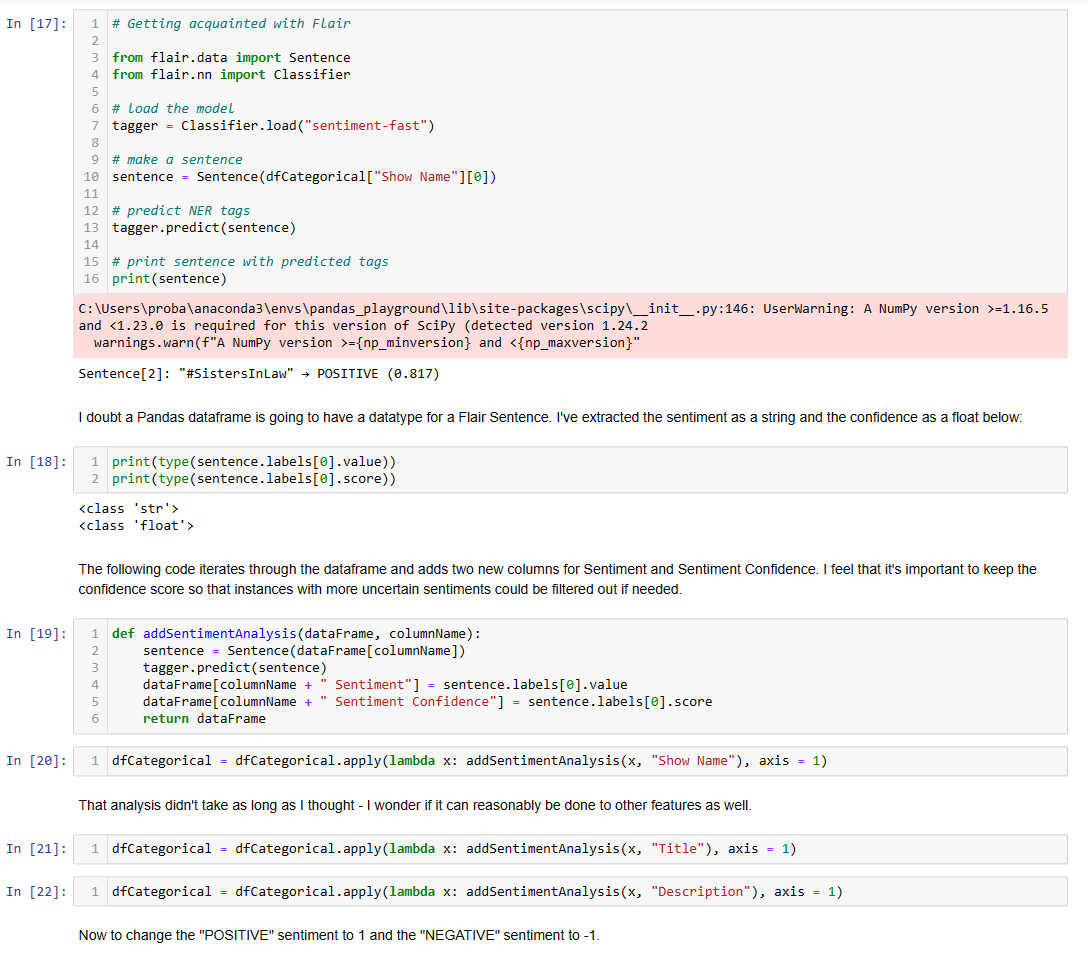

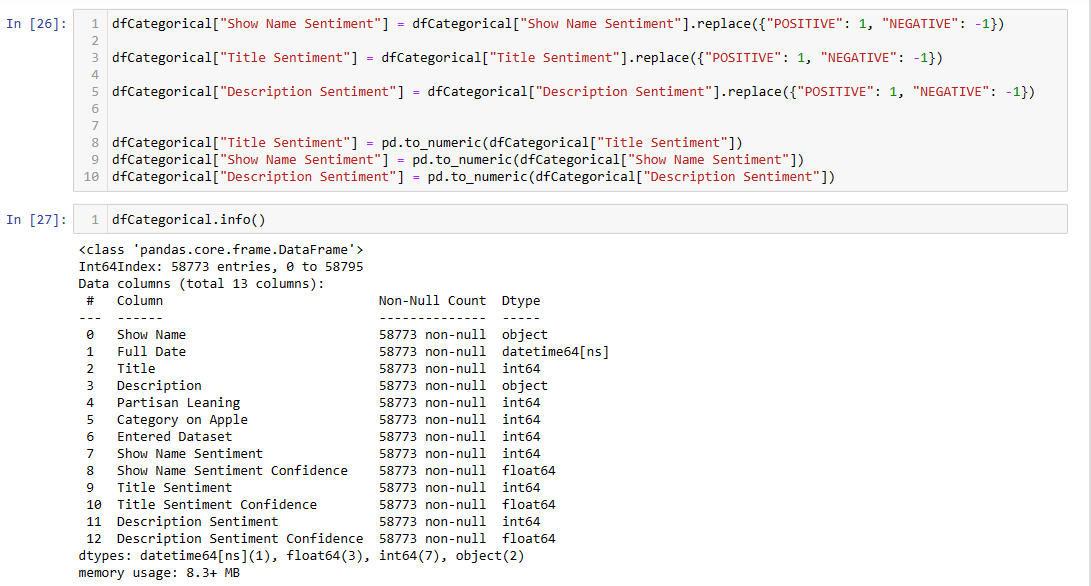

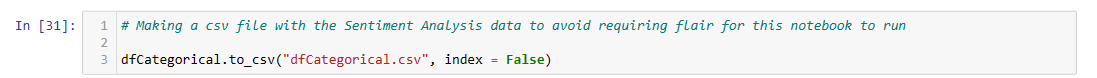

### ----- Start of Code Requiring flair -----

In [17]:
# # Getting acquainted with Flair

# from flair.data import Sentence
# from flair.nn import Classifier

# # load the model
# tagger = Classifier.load("sentiment-fast")

# # make a sentence
# sentence = Sentence(dfCategorical["Show Name"][0])

# # predict NER tags
# tagger.predict(sentence)

# # print sentence with predicted tags
# print(sentence)

I doubt a Pandas dataframe is going to have a datatype for a Flair Sentence. I've extracted the sentiment as a string and the confidence as a float below:

In [18]:
# print(type(sentence.labels[0].value))
# print(type(sentence.labels[0].score))

The following code iterates through the dataframe and adds two new columns for Sentiment and Sentiment Confidence. I feel that it's important to keep the confidence score so that instances with more uncertain sentiments could be filtered out if needed.

In [19]:
# def addSentimentAnalysis(dataFrame, columnName):
#     sentence = Sentence(dataFrame[columnName])
#     tagger.predict(sentence)
#     dataFrame[columnName + " Sentiment"] = sentence.labels[0].value
#     dataFrame[columnName + " Sentiment Confidence"] = sentence.labels[0].score
#     return dataFram

In [20]:
# dfCategorical = dfCategorical.apply(lambda x: addSentimentAnalysis(x, "Show Name"), axis = 1)

That analysis didn't take as long as I thought - I wonder if it can reasonably be done to other features as well.

In [21]:
# dfCategorical = dfCategorical.apply(lambda x: addSentimentAnalysis(x, "Title"), axis = 1)

In [22]:
# dfCategorical = dfCategorical.apply(lambda x: addSentimentAnalysis(x, "Description"), axis = 1)

Now to change the "POSITIVE" sentiment to 1 and the "NEGATIVE" sentiment to -1.

In [23]:
# dfCategorical["Show Name Sentiment"] = dfCategorical["Show Name Sentiment"].replace({"POSITIVE": 1, "NEGATIVE": -1})

# dfCategorical["Title Sentiment"] = dfCategorical["Title Sentiment"].replace({"POSITIVE": 1, "NEGATIVE": -1})

# dfCategorical["Description Sentiment"] = dfCategorical["Description Sentiment"].replace({"POSITIVE": 1, "NEGATIVE": -1})


# dfCategorical["Title Sentiment"] = pd.to_numeric(dfCategorical["Title Sentiment"])
# dfCategorical["Show Name Sentiment"] = pd.to_numeric(dfCategorical["Show Name Sentiment"])
# dfCategorical["Description Sentiment"] = pd.to_numeric(dfCategorical["Description Sentiment"])

In [24]:
# dfCategorical.info()

In [25]:
# Making a csv file with the Sentiment Analysis data to avoid requiring flair for this notebook to run

# dfCategorical.to_csv("dfCategorical.csv", index = False)

### ----- End of code requiring flair -----

## ----- Visualizing the data -----

### Metadata for dfCategorical

##### Partisan Leaning
- More Liberal: -1
- Moderate/Unknown: 0
- More Conservative: 1


##### Category on Apple
- News: 1
- Comedy: 2
- Science: 3
- Society & Culture: 4
- Education: 5
- Health & Fitness: 6
- Business: 7
- Religion & Spirituality: 8
- Arts: 9
- TV & Film: 10

##### Entered Dataset
- Apple Top 100: 1
- Apple Recommendation: 2

##### Show Name Sentiment
- Positive: 1
- Negative: -1

##### Title Sentiment
- Positive: 1
- Negative: -1

##### Description Sentiment
- Positive: 1
- Negative: -1

In [26]:
dfCategorical = pd.read_csv("dfCategorical.csv")
dfCategorical["Full Date"] = pd.to_datetime(dfCategorical["Full Date"])

In [27]:
dfCategorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58773 entries, 0 to 58772
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Show Name                         58773 non-null  object        
 1   Full Date                         58773 non-null  datetime64[ns]
 2   Title                             58773 non-null  object        
 3   Description                       58773 non-null  object        
 4   Partisan Leaning                  58773 non-null  int64         
 5   Category on Apple                 58773 non-null  int64         
 6   Entered Dataset                   58773 non-null  int64         
 7   Show Name Sentiment               58773 non-null  int64         
 8   Show Name Sentiment Confidence    58773 non-null  float64       
 9   Title Sentiment                   58773 non-null  int64         
 10  Title Sentiment Confidence        58773 non-nu

C:\Users\proba\anaconda3\envs\pandas_playground\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<AxesSubplot:>

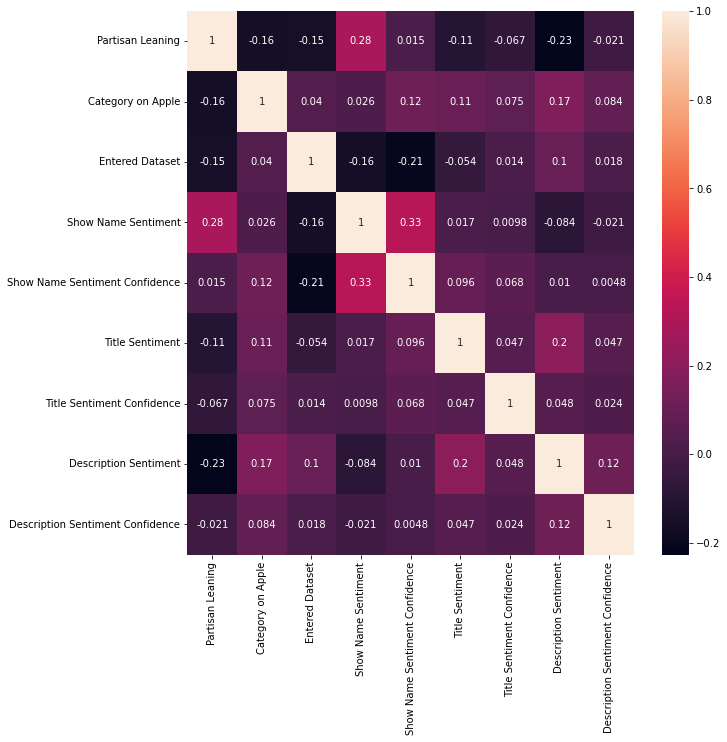

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
sns.heatmap(dfCategorical.corr(), annot = True)

Unfortunately, there are no strongly correlated features. I'd also like to avoid over-analyzing the relation between the Sentiment values and Sentiment Confidences, since this could be a result of Flair having an easier time identifying positive sentiment. I think having the Sentiment values and Sentiment Confidences is "muddying the waters" of the correlation matrix. I'm going to drop the Confidences and look again.

In [29]:
# Just overwriting the original "df," I don't see myself using it

df = dfCategorical.drop(["Title Sentiment Confidence", "Show Name Sentiment Confidence", 
                         "Description Sentiment Confidence"], axis = 1)

<AxesSubplot:>

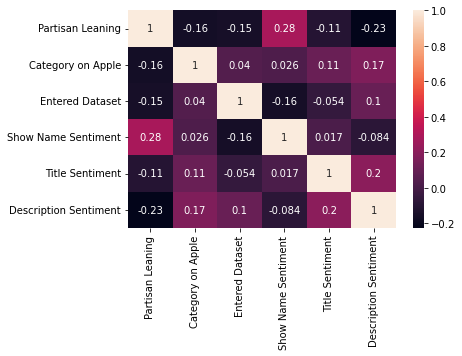

In [30]:
sns.heatmap(df.corr(), annot = True)

### Interesting Correlations (keeping in mind they are weak):

- Partisan Leaning/Show Name Sentiment: 0.28 - Conservative podcasts are more likely to have a name with a positive sentiment.
- Partisan Leaning/Description Sentiment: -0.23 - Liberal podcast episodes are more likely to have a description with a positive sentiment.
- Partisan Leaning/Title Sentiment: -0.11 - Episodes of Liberal podcasts are more likely to have a title with a positive sentiment

### Average Sentiments by date

I was hoping the Average Sentiment data around particularly divisive dates would look differently than Average Sentiment data in more "normal" times. 

I ended up having to convert the dataframe to a pivot table, then back to a dataframe. Plotting directly from the pivot table made working with the dates difficult.

In [31]:
import numpy as np

table = pd.pivot_table(df, index = ["Partisan Leaning", "Full Date"], values = "Title Sentiment", aggfunc = np.mean)

datesAsRows = table.pivot_table("Title Sentiment", index = "Full Date", columns = "Partisan Leaning")

datesAsRows

Partisan Leaning,-1,0,1
Full Date,,,
2012-09-02,NaN,1.000000,NaN
2012-09-04,NaN,1.000000,NaN
2012-09-05,NaN,1.000000,NaN
2012-09-10,NaN,1.000000,NaN
2012-09-11,NaN,1.000000,NaN
...,...,...,...
2023-03-12,-0.142857,1.000000,0.157895
2023-03-13,0.333333,0.000000,-0.209302
2023-03-14,-0.142857,0.142857,-0.074074


In [32]:
dfDatesAsRows = datesAsRows.reset_index()

In [33]:
dfDatesAsRows = dfDatesAsRows.rename_axis("Index")


dfDatesAsRows = dfDatesAsRows.rename(columns ={-1: "Avg Title Sentiment Liberal", 
                                               0: "Avg Title Sentiment Moderate/Unknown",
                                              1: "Avg Title Sentiment Conservative"})

### Average Sentiment of Podcast Episode Titles by Partisan Leaning of the Host(s): January 2021

(18628.0, 18658.0)

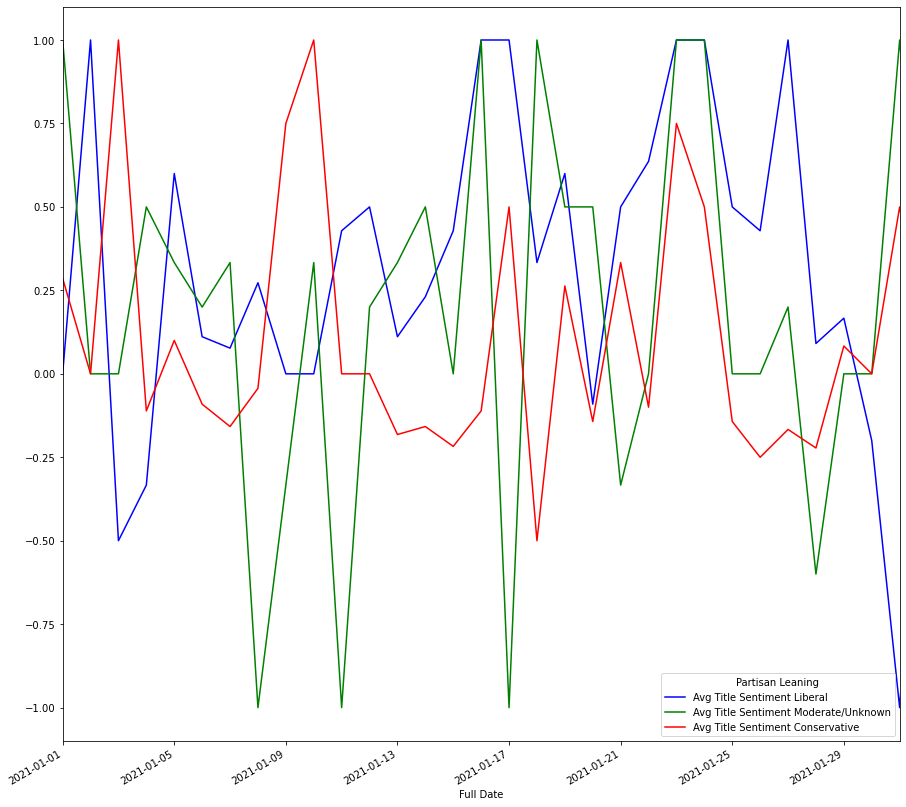

In [34]:
fig, ax = plt.subplots(figsize = (15,15))
dfDatesAsRows.plot.line(x = "Full Date", ax = ax,
                        
    color = {"Avg Title Sentiment Liberal": "blue", 
             "Avg Title Sentiment Moderate/Unknown": "green", 
             "Avg Title Sentiment Conservative": "red"})

# Change the arguments in the line below to look at a different date range
ax.set_xlim("2021-01-01", "2021-01-31")

### Average Sentiment of Podcast Episode Titles by Partisan Leaning of Host(s): January 2023

(19358.0, 19388.0)

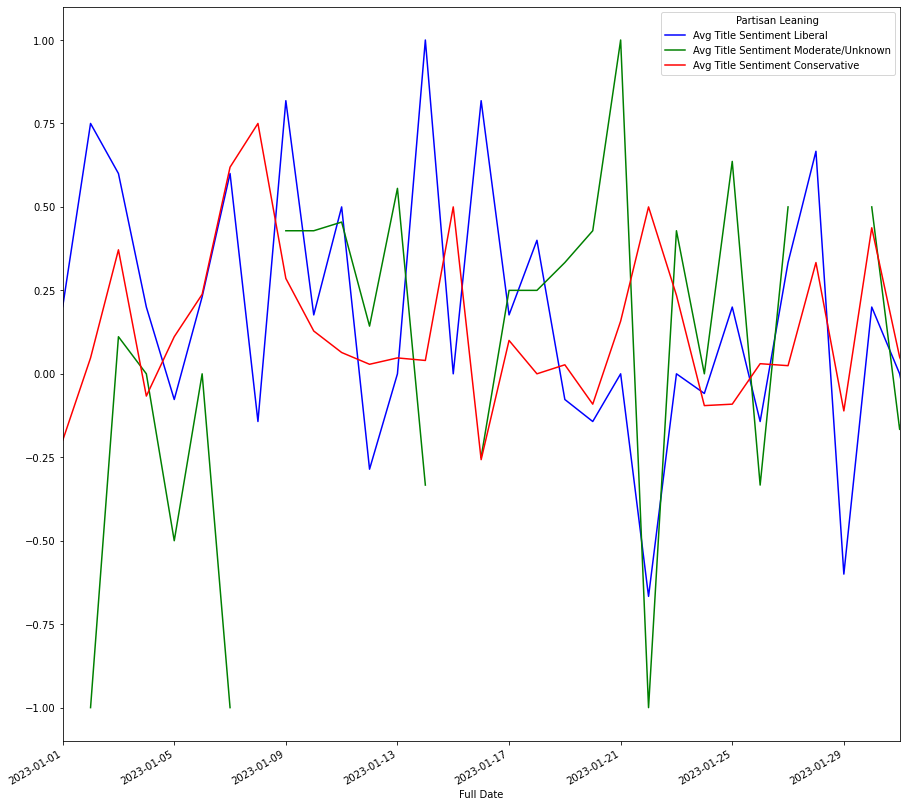

In [35]:
fig, ax = plt.subplots(figsize = (15,15))
dfDatesAsRows.plot.line(x = "Full Date", ax = ax,
                        
    color = {"Avg Title Sentiment Liberal": "blue", 
             "Avg Title Sentiment Moderate/Unknown": "green", 
             "Avg Title Sentiment Conservative": "red"})

# Change the arguments in the line below to look at a different date range
ax.set_xlim("2023-01-01", "2023-01-31")

### Final thoughts on Average Sentiment by date

The first chart above shows data for January 2021 - this seems like a good place to look because it includes the January 6th Capitol riot. Then below is data for January of this year, a somewhat more normal January. Visually, we can tell that the Average Sentiments have more variation in January 2021! Based on a few other quick visual comparisons, I think Machine Learning models could make use of the date data. However, I think that statistically "proving" this data is meaningful would take a more rigorous analysis involving the sum of podcast episodes released by Partisan Leaning, etc.

### One more data transformation...

I tried to train a Decision Tree in the next section using Full Date as a feature, but sklearn did not like the datetime64 datatype. Below, Full Date will be transformed into three columns: Day, Month, and Year.

In [36]:
# I thought there would be an easier way to do this...

def datetime64_to_DDMMYY(dataFrame, columnName):
    
    # date = "2023-03-11 00:00:00"
    date = str(dataFrame[columnName])
    
    #             Year    M     D     H   m  s
    # dateArr = ["2023", "03", "11", "00:00:00"]
    dateArr = date.replace(" ", "-").split("-")
    
    dataFrame["Day"] = int(dateArr[2]) 
    dataFrame["Month"] = int(dateArr[1])
    dataFrame["Year"] = int(dateArr[0][2:])
    
    return dataFrame


df = df.apply(lambda x: datetime64_to_DDMMYY(x, "Full Date"), axis = 1)

## ----- Machine Learning -----

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58773 entries, 0 to 58772
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Show Name              58773 non-null  object        
 1   Full Date              58773 non-null  datetime64[ns]
 2   Title                  58773 non-null  object        
 3   Description            58773 non-null  object        
 4   Partisan Leaning       58773 non-null  int64         
 5   Category on Apple      58773 non-null  int64         
 6   Entered Dataset        58773 non-null  int64         
 7   Show Name Sentiment    58773 non-null  int64         
 8   Title Sentiment        58773 non-null  int64         
 9   Description Sentiment  58773 non-null  int64         
 10  Day                    58773 non-null  int64         
 11  Month                  58773 non-null  int64         
 12  Year                   58773 non-null  int64         
dtypes

Above is a summary of the dataframe that I would like to use to train the model.

### Defining the Training/Test data

The Training and Test data will be used to train models that will attempt to classify a podcast host(s) Partisan Leaning based on: Category on Apple, Show Name Sentiment, Title Sentiment, Description Sentiment, and the Date data (Day, Month, Year).

"stratify = df[target]" is used to make sure that the training and test data will have the target classes (-1, 0, 1) present in equal proportion.

In [38]:
from sklearn.model_selection import train_test_split

features = ["Category on Apple", "Show Name Sentiment", 
            "Title Sentiment", "Description Sentiment", "Day", "Month", "Year"]

target = ["Partisan Leaning"]

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size = 0.4, 
                                                    random_state = 23, stratify = df[target])

### Decision Tree - Training the Model

In [39]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier()
dTree.fit(X_train, y_train)

DecisionTreeClassifier()

### Decision Tree - Testing the Model

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


predictionsDTree = dTree.predict(X_test)
acc = accuracy_score(y_test, predictionsDTree)

print("Accuracy:", acc, "\n")
print(classification_report(y_test, predictionsDTree))

Accuracy: 0.6965971926839643 

              precision    recall  f1-score   support

          -1       0.60      0.58      0.59      5644
           0       0.39      0.31      0.35      3136
           1       0.78      0.82      0.80     14730

    accuracy                           0.70     23510
   macro avg       0.59      0.57      0.58     23510
weighted avg       0.68      0.70      0.69     23510



The Decision Tree made above used the default values: max_leaf_nodes = 2 and min_samples_split = 2.

Let's see if the accuracy can be improved.

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

params = {"max_leaf_nodes": list(range(2,100)), "min_samples_split": [2,3,4,5,6]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state = 23), params, cv = 3)
grid_search_cv.fit(X_train, y_train)

The optimal number for max_leaf_nodes will be saved to numLeafNodes. The optimal value for min_samples_split will be saved to minSamplesSplit

In [ ]:
numLeafNodes = grid_search_cv.best_params_.get("max_leaf_nodes")
minSamplesSplit = grid_search_cv.best_params_.get("min_samples_split")

print("Optimal max_leaf_nodes: ", numLeafNodes)
print("Optimal min_samples_split: ", minSamplesSplit)

### Decision Tree - Hyperparameter Tuning

In [ ]:
dTree = DecisionTreeClassifier(max_leaf_nodes = numLeafNodes, min_samples_split = minSamplesSplit)
dTree.fit(X_train, y_train)

In [ ]:
%%time

predictionsDTree = dTree.predict(X_test)
acc = accuracy_score(y_test, predictionsDTree)

print("Accuracy:", acc, "\n")
print(classification_report(y_test, predictionsDTree))

The Decision Tree's metrics always improve after Hyperparameter tuning.

### Support Vector Machine - Training the Model

I tried to use grid_search_cv to find the best values for hyperparameters: C and gamma for an RBF SVM. Even with just trying three different values for C and gamma, the code never finished execution. Instead of attempting to tune C and gamma, the following section tunes the SVM by selecting the better kernel between RBF and Linear.

#### Radial Basis Function (RBF) kernel

In [ ]:
%%time

from sklearn import svm

# SVC = Support Vector Classification
svmRBF = svm.SVC(kernel = "rbf", random_state = 23)

# "y_train.values.ravel()" used instead of "y_train" to prevent a warning
svmRBF.fit(X_train, y_train.values.ravel())

#### Linear kernel

In [ ]:
%%time

svmLinear = svm.SVC(kernel = "linear", random_state = 23)
svmLinear.fit(X_train, y_train.values.ravel())

### SVM - Testing the Models

#### Radial Basis Function (RBF) kernel

In [ ]:
%%time

predictionsSVM_RBF = svmRBF.predict(X_test)
acc = accuracy_score(y_test, predictionsSVM_RBF)

print("Accuracy:", acc, "\n")
print(classification_report(y_test, predictionsSVM_RBF))

#### Linear kernel

##### The recall for 0 (Moderate/Unknown) may be 0.00. This will cause a warning to be displayed.

In [ ]:
%%time

predictionsSVM_Linear = svmLinear.predict(X_test)
acc = accuracy_score(y_test, predictionsSVM_Linear)

print("Accuracy:", acc, "\n")
print(classification_report(y_test, predictionsSVM_Linear))

### Selecting the better kernel: RBF

The linear kernel seems like it doesn't work well with this data; it never classifies an instance as 0 (Moderate/Unknown). Going forward, the SVM with an RBF kernel will be used.

## ----- Comparisons -----

### The better model: The Decision Tree

According to the classification report, the Decision Tree outperforms the SVM by every metric. 

##### But why was the Decision Tree the better model?
I think it was because it was easy to change the hyperparameters. It was simple and quick to find the optimal values of max_leaf_nodes and min_samples_split for the Decision Tree. On the other hand, the SVM has many potential kernels: linear, polynomial, RBF, sigmoid, or precomputed. The hyperparameter C (the Regularization parameter) is the size of the margin around the hyperplane used to classify instances - this is used in all kernel types. Some kernels have unique hyperparameters, for example, polynomial has "degree." Because of hardware limitations and because the SVMs are so varied and complex, I couldn't explore many tuning options. It's very possible that there is an SVM that would outperform the Decision Tree on this data if given the right hyperparameters. 

In [ ]:
print("    ====== Decision Tree Classification Report ======\n")
print(classification_report(y_test.reset_index(drop = True), predictionsDTree))

print("\n\n    ====== SVM (RBF kernel) Classification Report =====\n")
print(classification_report(y_test, predictionsSVM_RBF))

### Confusion Matrices

Surprisingly, translating the metrics to a Confusion Matrix was not straightforward. The following cell is heavily commented to explain how the data is translated into a more useful format. The cell for the SVM confusion Matrix will not be as heavily commented.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


confusionMatrix = confusion_matrix(y_test, predictionsDTree)

# =================================================================================================

# The following three lines are an easier way to display the confusion matrix, but it wasn't
# as easy to work with as using Seaborn.

# cm_display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix)
# cm_display.plot(cmap = "plasma")
# plt.show()

# -------------------------------------------------------------------------------------------------

# Using Seaborn to display the Confusion Matrix

fig, ax = plt.subplots(figsize = (10, 8))

# fmt = "g": disable scientific notation
ax = sns.heatmap(confusionMatrix, annot = True, fmt = "g", linewidth = 3, linecolor = "white", cmap = "viridis")

# y = 1.08: Offset y position of title
ax.set_title("Confusion Matrix for Decision Tree", y = 1.05, fontsize = 20)

## labelpad = 30: Spacing from the Axes bounding box
ax.set_xlabel("Predicted Partisan Leaning", labelpad = 30, fontsize = 15)
ax.set_ylabel("Actual Partisan Leaning", labelpad = 30, fontsize = 15)

# Without setting the tick labels here, the labels default to 0, 1, 2 (Liberal, Moderate/Unknown, Conservative)
# That could be confusing since the dataframe has Liberal, Moderate/Unknown, Conservative transformed to -1, 0, 1
# (This situation is why I'm using Seaborn to better format the matrix)

ax.xaxis.set_ticklabels(["More Liberal", "Moderate/Unknown", "More Conservative"], fontsize = 12);
ax.yaxis.set_ticklabels(["More Liberal", "Moderate/Unknown", "More Conservative"], fontsize = 12);

In [ ]:
confusionMatrix = confusion_matrix(y_test, predictionsSVM_RBF)

fig, ax = plt.subplots(figsize = (10, 8))

ax = sns.heatmap(confusionMatrix, annot = True, fmt = "g", linewidth = 3, linecolor = "white", cmap = "viridis")

ax.set_title("Confusion Matrix for SVM (RBF Kernel)", y = 1.05, fontsize = 20)
ax.set_xlabel("Predicted Partisan Leaning", labelpad = 30, fontsize = 15)
ax.set_ylabel("Actual Partisan Leaning", labelpad = 30, fontsize = 15)
ax.xaxis.set_ticklabels(["More Liberal", "Moderate/Unknown", "More Conservative"], fontsize = 12);
ax.yaxis.set_ticklabels(["More Liberal", "Moderate/Unknown", "More Conservative"], fontsize = 12);

## ----- Trying new instances (requires flair) -----

### Enter the Podcast information in this cell

In [ ]:
# See the integer to use below
categoryOnApple = 2

showName = "Knowledge Fight"
episodeTitle = "#785: March 4, 2023"
description = """Today, Dan and Jordan return to the studio to check in on something they missed while taking a little breaky: the groundbreaking interview Alex had with Roseanne Barr."""

# Use Integers
dayPosted = 4
monthPosted = 3

# Only use the last two years: 2023 = 23
yearPosted = 23

##### Category on Apple:
- News: 1
- Comedy: 2
- Science: 3
- Society & Culture: 4
- Education: 5
- Health & Fitness: 6
- Business: 7
- Religion & Spirituality: 8
- Arts: 9
- TV & Film: 10

### Results (do not modify the code in this cell)
#### (Highlight all text in the cell and enter Ctrl+/ to uncomment)

In [ ]:
from flair.data import Sentence
from flair.nn import Classifier

# =======================================================================================================
#                                            Get sentiments
# =======================================================================================================
def getSentiments(showName, episodeTitle, description):
    nameVal = 1
    epVal = 1
    descVal = 1
    
    tagger = Classifier.load("sentiment-fast")
    
    name = Sentence(showName)
    title = Sentence(episodeTitle)
    desc = Sentence(description)
    
    tagger.predict(name)
    tagger.predict(title)
    tagger.predict(desc)
    
    if(name.labels[0].value == "NEGATIVE"):
        nameVal = -1
        
    if(title.labels[0].value == "NEGATIVE"):
        epVal = -1
        
    if(desc.labels[0].value == "NEGATIVE"):
        descVal = -1
        
    return nameVal, epVal, descVal 

showNameSent, episodeTitleSent, descriptionSent = getSentiments(showName, episodeTitle, description)
# ----------------------------------------------------------------------------------------------------------


# The features
podcast = pd.DataFrame ([{
    
    "Category on Apple": categoryOnApple,
    "Show Name Sentiment": showNameSent,
    "Title Sentiment": episodeTitleSent,
    "Description Sentiment": descriptionSent,
    "Day": dayPosted,
    "Month": monthPosted,
    "Year": yearPosted
}])

pred = dTree.predict(podcast)


# ===================================================================
#                          Display
# ===================================================================

# --------------- Was it in the original dataset? -------------------

if(df["Show Name"].eq(showName).any()):
    print("An episode of", showName, "is in the original dataset.\n")
else:
    print("There is no episode of", showName, "in the original dataset.\n")


# ----------------- What were the sentiments? ---------------------
print("\nSentiments (1 = POSITIVE, -1 = NEGATIVE):\n")
print("Show Name Sentiment:", showNameSent, 
      "\nEpisode Title Sentiment:", episodeTitleSent, 
      "\nDescription Sentiment:", descriptionSent)

#---------------------------- Result ------------------------------
print("\n\n" + showName, "is predicted to have host(s) that are: ")

if(pred == -1):
    print("More Liberal")
elif(pred == 0):
    print("Moderate/Unknown")
elif(pred == 1):
    print("More Conservative")

## Citations

### Flair

[Contextual String Embeddings for Sequence Labeling](https://aclanthology.org/C18-1139) (Akbik et al., COLING 2018)<br>
[FLAIR: An Easy-to-Use Framework for State-of-the-Art NLP](https://aclanthology.org/N19-4010) (Akbik et al., NAACL 2019)

### Popular Political Podcasts Dataset developed by Valerie Wirtschafter and Chris Meserole at the Brookings Institution

https://politicalpodcastproject.shinyapps.io/dataset/